In [1]:
%%capture
!pip install googletrans==3.1.0a0 # for english checking
!pip install unidecode

# vncorenlp
!pip install vncorenlp
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr

# vietnamese stopword
!wget https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt

In [2]:
!mkdir -p vncorenlp/models/wordsegmenter

In [3]:
!mkdir -p vncorenlp/models/wordsegmenter
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

In [4]:
import pandas as pd
import numpy as np
import re
from itertools import chain

from unidecode import unidecode
from vncorenlp import VnCoreNLP

# Detect English
from googletrans import Translator

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# data path
DATA_PATH = '/content/drive/MyDrive/Public/DS102 - Machine Learning/data/job-markets-vn.csv'
VI_DATA_PATH = '/content/drive/MyDrive/Public/DS102 - Machine Learning/data/vi_job-markets-vn.csv'
PROCESSED_VI_DATA_PATH = '/content/drive/MyDrive/Public/DS102 - Machine Learning/data/p_vi_job-markets-vn.csv'

# vietnamese stopwords
STOPWORD_PATH = 'vietnamese-stopwords.txt'

# all labels
JOB_LABELS_PATH = '/content/drive/MyDrive/Public/DS102 - Machine Learning/data/job_labels.csv'

# saving path
TRAIN_PATH = '/content/drive/MyDrive/Public/DS102 - Machine Learning/data/train.csv'
DEV_PATH = '/content/drive/MyDrive/Public/DS102 - Machine Learning/data/dev.csv'
TEST_PATH = '/content/drive/MyDrive/Public/DS102 - Machine Learning/data/test.csv'

# Load Data

In [ ]:
df = pd.read_csv(DATA_PATH)

In [ ]:
df.columns

Index(['date', 'title', 'industry', 'mapped_industry', 'level', 'min_year',
       'max_year', 'min_salary', 'max_salary', 'city', 'description',
       'requirement'],
      dtype='object')

In [ ]:
df.sample(2)[['description']]

,description
14239,- Có kinh nghiệm ít nhất 6 tháng trong lĩnh vự...
7780,"Business Development Manager, Vietnam, Engage ..."


In [ ]:
df.shape

(20000, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             20000 non-null  object 
 1   title            20000 non-null  object 
 2   industry         20000 non-null  object 
 3   mapped_industry  20000 non-null  object 
 4   level            20000 non-null  object 
 5   min_year         17018 non-null  float64
 6   max_year         5247 non-null   float64
 7   min_salary       13853 non-null  float64
 8   max_salary       13774 non-null  float64
 9   city             20000 non-null  object 
 10  description      19999 non-null  object 
 11  requirement      9554 non-null   object 
dtypes: float64(4), object(8)
memory usage: 1.8+ MB


In [ ]:
df[df['description'].isnull()]

,date,title,industry,mapped_industry,level,min_year,max_year,min_salary,max_salary,city,description,requirement
4399,2023-04-28,Enterprise Sales Lead (IT),"5, 21, 30","Bán buôn - Bán lẻ - Quản lý cửa hàng, IT Phần ...",Quản lý cấp trung,NaN,NaN,NaN,NaN,TP.HCM,NaN,NaN


In [ ]:
df = df[df['description'].notna()]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19999 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             19999 non-null  object 
 1   title            19999 non-null  object 
 2   industry         19999 non-null  object 
 3   mapped_industry  19999 non-null  object 
 4   level            19999 non-null  object 
 5   min_year         17018 non-null  float64
 6   max_year         5247 non-null   float64
 7   min_salary       13853 non-null  float64
 8   max_salary       13774 non-null  float64
 9   city             19999 non-null  object 
 10  description      19999 non-null  object 
 11  requirement      9554 non-null   object 
dtypes: float64(4), object(8)
memory usage: 2.0+ MB


# Preprocessing
- Xóa tất cả các dòng tiếng Anh
- Lower case
- Xóa các ký tự đặc biệt: #, , & *, $,...
- Tokenization: VnNLPCore
- Xóa các stop word

## Xóa tất cả các dòng tiếng Anh

In [ ]:
detector = Translator()

def is_vietnamese(text):
    dec_lan = detector.detect(text)
    return dec_lan.lang == 'vi'

vi = df['description'].apply(is_vietnamese)

In [ ]:
vi_data = df[vi]
vi_data.shape, vi_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15672 entries, 1 to 19999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             15672 non-null  object 
 1   title            15672 non-null  object 
 2   industry         15672 non-null  object 
 3   mapped_industry  15672 non-null  object 
 4   level            15672 non-null  object 
 5   min_year         13968 non-null  float64
 6   max_year         4652 non-null   float64
 7   min_salary       12513 non-null  float64
 8   max_salary       12418 non-null  float64
 9   city             15672 non-null  object 
 10  description      15672 non-null  object 
 11  requirement      5483 non-null   object 
dtypes: float64(4), object(8)
memory usage: 1.6+ MB


((15672, 12), None)

In [ ]:
# save vietnamese dataset
vi_data = vi_data.reset_index().drop('index', axis=1)
vi_data.to_csv(VI_DATA_PATH, index=False)

In [89]:
vi_data = pd.read_csv(VI_DATA_PATH)

6787 trong tập vi_data

## Lower case, xóa ký tự đặc biệt, xóa stopword

In [90]:
vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

In [91]:
# vi stopword
with open(STOPWORD_PATH, 'r') as file:
    vi_stopwords = file.readlines()
vi_stopwords = [sw.strip() for sw in vi_stopwords if sw.strip()]

In [92]:
def preprocess(txt):
    # Lower case
    txt = txt.lower()
    # Tokenization
    txt = vncorenlp.tokenize(txt)
    txt = list(chain.from_iterable(txt))
    # Special character removal
    txt = remove_characters(txt)
    txt = list(filter(lambda x: x != '', txt))

    txt = ' '.join(txt).replace('_', ' ')
    return txt.strip()

# Remove special characters & stopwords
def remove_characters(txt_data):
    cleaned = []
    for token in txt_data:
        if token not in vi_stopwords:
            # if token.replace('_', '').isalpha():
            if is_word(unidecode(token)):
                # cleaned_token = re.sub(r"[-()\"#/@;:<>{}`+=~|!?,]", "", token)
                # cleaned.append(cleaned_token)
                cleaned.append(token)
    return cleaned

def is_word(element):
    pattern = r'^\w+$'
    return re.match(pattern, element) is not None

In [93]:
vi_data['description'] = vi_data['description'].map(preprocess)
vi_data['requirement'] = vi_data['requirement'].fillna('').map(preprocess)

In [94]:
vi_data.to_csv(PROCESSED_VI_DATA_PATH, index=False)

## Unique job labels

In [95]:
uni_job_labels = vi_data['mapped_industry'].str.cat(sep=', ')
uni_job_labels = set(uni_job_labels.split(", "))

In [96]:
uni_job_labels = list(uni_job_labels)
uni_job_labels_len = len(uni_job_labels)
print('Số lượng nhãn: ', uni_job_labels_len, ' ngành nghề')

Số lượng nhãn:  69  ngành nghề


In [97]:
uni_job_labels_pd = pd.DataFrame(list(uni_job_labels))
uni_job_labels_pd

,0
0,Kinh doanh
1,Internet - Online Media
2,Thương mại điện tử
3,Điện - Điện tử
4,Kế toán
...,...
64,Tự động hóa - Ô tô
65,IT Phần mềm
66,Người nước ngoài - Việt Kiều
67,Ngân hàng


In [98]:
# save
uni_job_labels_pd.to_csv(JOB_LABELS_PATH, index=False)

## Change ',' to '/'

In [99]:
vi_data['mapped_industry'] = vi_data['mapped_industry'].map(lambda x: x.replace(', ', ' / '))

## Train, dev, test
* Train: 0.7
* Dev: 0.2
* Test: 0.1

In [143]:
from sklearn.model_selection import train_test_split

In [144]:
train, dev = train_test_split(vi_data, test_size=0.3, random_state=42)
dev, test = train_test_split(dev, test_size=1-0.66667, random_state=42)

In [145]:
train.shape, dev.shape, test.shape

((10970, 12), (3134, 12), (1568, 12))

In [146]:
train.shape[0] / len(vi_data), dev.shape[0] / len(vi_data), test.shape[0] / len(vi_data)

(0.6999744767738643, 0.1999744767738642, 0.10005104645227157)

In [147]:
# save
train = train[train['description'] != '']
dev = dev[dev['description'] != '']
test = test[test['description'] != '']

train.to_csv(TRAIN_PATH, index=False)
dev.to_csv(DEV_PATH, index=False)
test.to_csv(TEST_PATH, index=False)

# Visulization

## All Job Titles

In [ ]:
uni_job_labels_pd

,0
0,Nghề nghiệp khác
1,Bán buôn - Bán lẻ - Quản lý cửa hàng
2,Bán hàng kỹ thuật
3,Kế toán
4,IT Phần mềm
...,...
64,Điện - Điện tử
65,Tự động hóa - Ô tô
66,Nông - Lâm - Ngư nghiệp
67,Biên phiên dịch


## Số lượng sample của Train, Dev và Test

In [ ]:
train.shape, dev.shape, test.shape

((10970, 12), (3134, 12), (1568, 12))

## Maxlen, Minlen, Avglen từng tập

In [ ]:
def txt_len(txt):
    txt = txt.split(' ')
    return len(txt)

In [ ]:
train_len = [txt_len(txt) for txt in train['description'].tolist()]
dev_len = [txt_len(txt) for txt in dev['description'].tolist()]
test_len = [txt_len(txt) for txt in test['description'].tolist()]

In [ ]:
# Train
print('Max_len of Train: ', max(train_len))
print('Min_len of Train: ', min(train_len))
print('Avg_len of Train: ', np.mean(train_len))
print()

# Dev
print('Max_len of Dev: ', max(dev_len))
print('Min_len of Dev: ', min(dev_len))
print('Avg_len of Dev: ', np.mean(dev_len))
print()

# Train
print('Max_len of Test: ', max(test_len))
print('Min_len of Test: ', min(test_len))
print('Avg_len of Test: ', np.mean(test_len))
print()

Max_len of Train:  1213
Min_len of Train:  1
Avg_len of Train:  92.81312670920693

Max_len of Dev:  1116
Min_len of Dev:  2
Avg_len of Dev:  92.87236758136567

Max_len of Test:  1137
Min_len of Test:  4
Avg_len of Test:  93.14094387755102



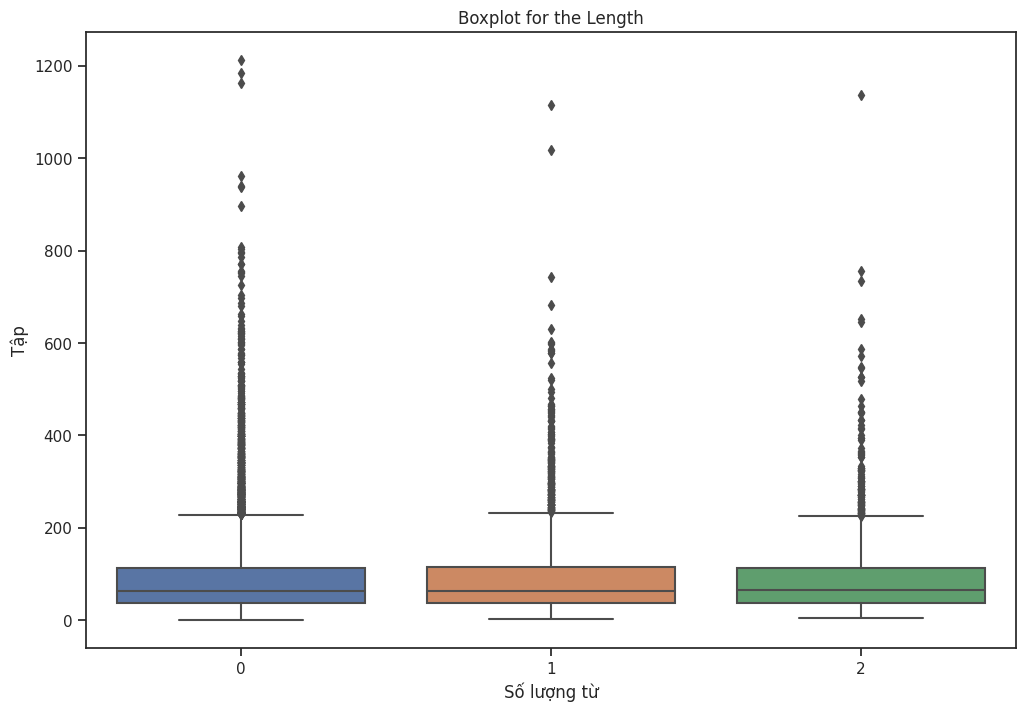

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks")
plt.figure(figsize=(12, 8))
sns.boxplot(data=[train_len, dev_len, test_len], orient="v")
plt.xlabel('Số lượng từ')
plt.ylabel('Tập')
plt.title('Boxplot for the Length')

# Show the plot
plt.show()

## Số lượng label từ sample

In [ ]:
def count_label(label):
    label = label.split(' / ')
    return len(label)

In [ ]:
train_count_label = pd.Series([count_label(l) for l in train['mapped_industry'].tolist()])
dev_count_label = pd.Series([count_label(l) for l in dev['mapped_industry'].tolist()])
test_count_label = pd.Series([count_label(l) for l in test['mapped_industry'].tolist()])

In [ ]:
counts_df = pd.DataFrame({
    'train': train_count_label.value_counts(),
    'dev': dev_count_label.value_counts(),
    'test': test_count_label.value_counts()
    }
)
counts_df

,train,dev,test
3,6878,1954,974
2,2238,639,322
1,1854,541,272


In [ ]:
groups = ['1 nhãn', '2 nhãn', '3 nhãn']
attributes = ['Train', 'Dev', 'Test']
values = [counts_df['train'], counts_df['dev'], counts_df['test']]

# Reshape the data into long format
data = []
for i, group in enumerate(groups):
    for j, attribute in enumerate(attributes):
        data.append([group, attribute, values[i][j]])

# Convert the data to a Pandas DataFrame
df = pd.DataFrame(data, columns=['Group', 'Attribute', 'Value'])

# Set the style
sns.set(style="ticks")

# Create the bar plot using Seaborn
sns.barplot(x='Group', y='Value', hue='Attribute', data=df)

# Set the labels and title
plt.xlabel('Tập')
plt.ylabel('Số lượng')
plt.title('Số lượng nhãn với từng job descri')

# Show the plot
plt.show()

KeyError: ignored